# Time-series analysis

Researchers have measured a bivariate timeseries, but the equipment was unreliable so the data has gaps as well as noise. The data can be found in [data.csv](https://gist.github.com/tmramalho/51733432c88e2b834dbd70353849f887)

In this exercise, we want to train an [MLP](https://en.wikipedia.org/wiki/Multilayer_perceptron) to regress the full observed trajectory from the measured data. Formally, the MLP will be used to approximate the function $f:\mathbb{R} \rightarrow \mathbb{R}^2 ; f(t) = (x(t), y(t))$. In other words, the model takes the current time as an input, and predicts the values of `x` and `y` at that time based only on the measured data.

Your task is to define the data loader, the MLP model and the loss function to complete this task successfully. For this problem you will need to use a regression loss, not a classification loss.

Successful training should result in a data interpolation similar to the below:
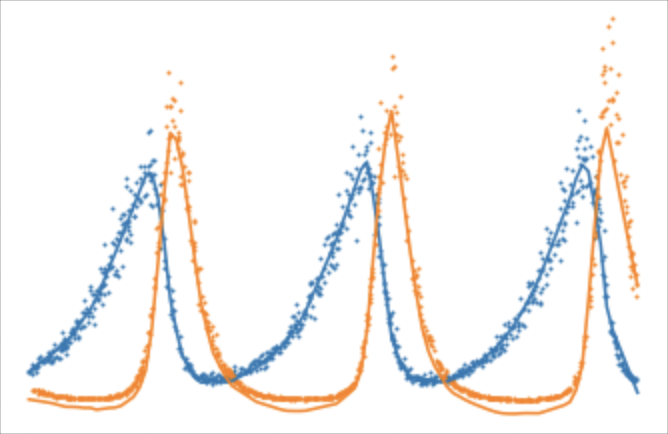

#Solution Remarks

##Gaps in the data and Noise
Some records have full set of labels while others are incomplete. As we always have input feature t, we can still learn to predict existing label just fine. We need to ensure however to accumulate correct amount of error (depending how many labels are available).

Optimizer choice is Adam as it is recommended choice for regression problems due to adaptive learning rate adjustments. More complicated problems might require more sophisticated navigation of gradient landscape such as LBFGS (for instance optimizing objectives on 3D manifolds).

I interpret requirements as we cannot use interpolation or prediction techniques (predict based on measured data only) such as Particle Filter, but they also are possible consideration depending on the problem.

We can guide predictions into smooth shape using regularization techniques such as loss function robust to outliers such as Huber Loss. In my past work and hobby projects I have used Data Augmentation techniques (generating rigid transformations of images). In my Master's Thesis I had utilized reduced number of neurons in backbone GAN and relied on post processing techniques, which enhanced final result.

As I understand it, this part is not typical time series prediction, but we have to teach model to approximate function well within existing data domain.

In [ ]:
!wget https://gist.githubusercontent.com/tmramalho/51733432c88e2b834dbd70353849f887/raw/676636d9e8512963005a318cb9b98060feadb641/data.csv

--2024-10-04 19:24:03--  https://gist.githubusercontent.com/tmramalho/51733432c88e2b834dbd70353849f887/raw/676636d9e8512963005a318cb9b98060feadb641/data.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49992 (49K) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]  48.82K  --.-KB/s    in 0.03s   

2024-10-04 19:24:03 (1.81 MB/s) - ‘data.csv’ saved [49992/49992]



Finished Training


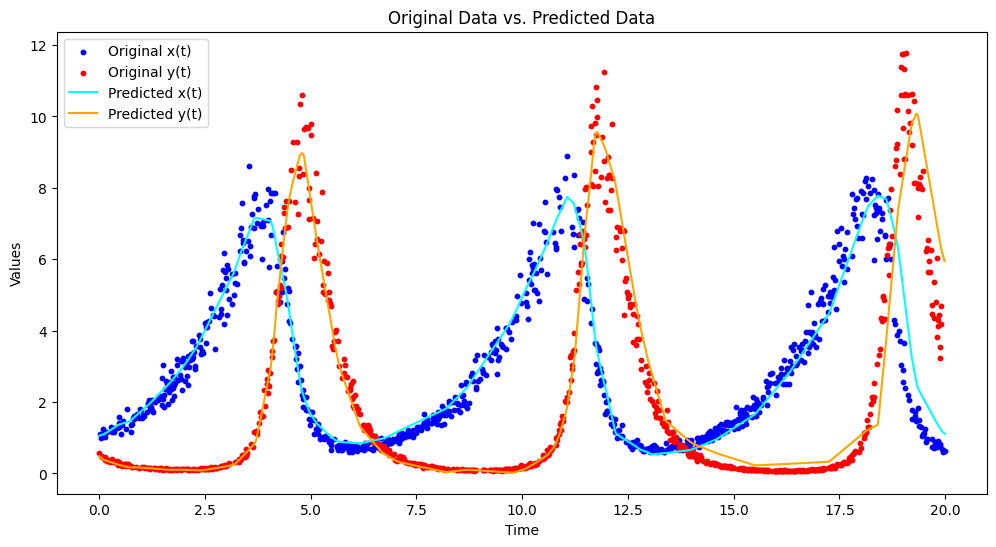

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

BATCH_SIZE = 32

class Net(nn.Module):
    '''Model to regress 2D time series values given scalar input.'''
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 2)

    def forward(self, x):
        x = x.view(-1, 1)
        x = F.relu(self.fc1(x))
        #x = self.dropout(x)
        x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        x = F.relu(self.fc3(x))
        #x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

class TimeSeriesDataset(torch.utils.data.Dataset):
    '''Custom Dataset for loading time series data with missing values.'''
    def __init__(self, csv_file):
        data = pd.read_csv(csv_file, na_values='-')
        self.times = data['t'].values.astype(np.float32)
        self.x_values = data['x'].astype(np.float32).values
        self.y_values = data['y'].astype(np.float32).values

    def __len__(self):
        return len(self.times)

    def __getitem__(self, idx):
        t = self.times[idx]
        x = self.x_values[idx]
        y = self.y_values[idx]
        labels = np.array([0.0, 0.0], dtype=np.float32)
        mask = np.array([0.0, 0.0], dtype=np.float32)
        if not np.isnan(x):
            labels[0] = x
            mask[0] = 1.0
        if not np.isnan(y):
            labels[1] = y
            mask[1] = 1.0
        return torch.tensor([t]), torch.tensor(labels), torch.tensor(mask)

dataset = TimeSeriesDataset('data.csv')
trainloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

def loss_fn(outputs, labels, mask, delta=1.0):
    error = outputs - labels
    is_small_error = (error.abs() <= delta).float()
    squared_loss = 0.5 * error ** 2
    linear_loss = delta * (error.abs() - 0.5 * delta)
    loss = (is_small_error * squared_loss + (1 - is_small_error) * linear_loss) * mask
    loss = loss.sum() / mask.sum()
    return loss

net = Net()
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in range(300):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels, mask = data
        inputs = inputs.float()
        labels = labels.float()
        mask = mask.float()

        optimizer.zero_grad()

        outputs = net(inputs)

        loss = loss_fn(outputs, labels, mask)

        loss.backward()
        optimizer.step()

print('Finished Training')

plt.figure(figsize=(12, 6))

plt.scatter(dataset.times[~np.isnan(dataset.x_values)],
            dataset.x_values[~np.isnan(dataset.x_values)],
            label='Original x(t)', color='blue', s=10)

plt.scatter(dataset.times[~np.isnan(dataset.y_values)],
            dataset.y_values[~np.isnan(dataset.y_values)],
            label='Original y(t)', color='red', s=10)

with torch.no_grad():
    times = torch.linspace(dataset.times.min(), dataset.times.max(), steps=1000)
    predicted = net(times.unsqueeze(1))
    predicted = predicted.numpy()

plt.plot(times.numpy(), predicted[:, 0], label='Predicted x(t)', color='cyan')
plt.plot(times.numpy(), predicted[:, 1], label='Predicted y(t)', color='orange')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Original Data vs. Predicted Data')
plt.show()


# Time-series extension

The simplified model above will only work well if $t\in[0,20]$.
Create a different model that can extrapolate `x,y` predictions to $t>20$.
Assume that the model has access to the same data as above, and is tasked to predict up to $t=100$. You can change anything in the above setup as needed, including model architecture, loss function, training procedure or data loader.

There are several different correct approaches to tackle this problem, all with different pros and cons, so make sure to explain your reasoning for the different choices made.


# Solution Remarks

One technique for such problem is modeling temporal dependencies through specialized neural network like in RNNs, Attention or LSTM architectures.
Such approach allows for capturing most complex data patterns, at the expense of memory and computation intensity.

Another idea is manual re-modeling of input to the network. Instead of t which is open-bound at infinity, we can process it through periodic functions such as Sine and Cosine. However, this might be sensitive especially to frequency of periodic function, as we can confuse network if chosen inappropriately. One approach I tried in the past is analyzing sequence with Fourier Transform and extracting dominating frequencies. Then, thanks to Inverse FT, one can approximate the function.

There are projects utilizing periodic activation functions i.e. SIREN Networks https://www.vincentsitzmann.com/siren/ or Alias-Free StyleGAN.

Below I present solution where I use Fourier Features. The idea is that we should capture periodic behaviour and remain sensitive to small changes in input.

Finished Training


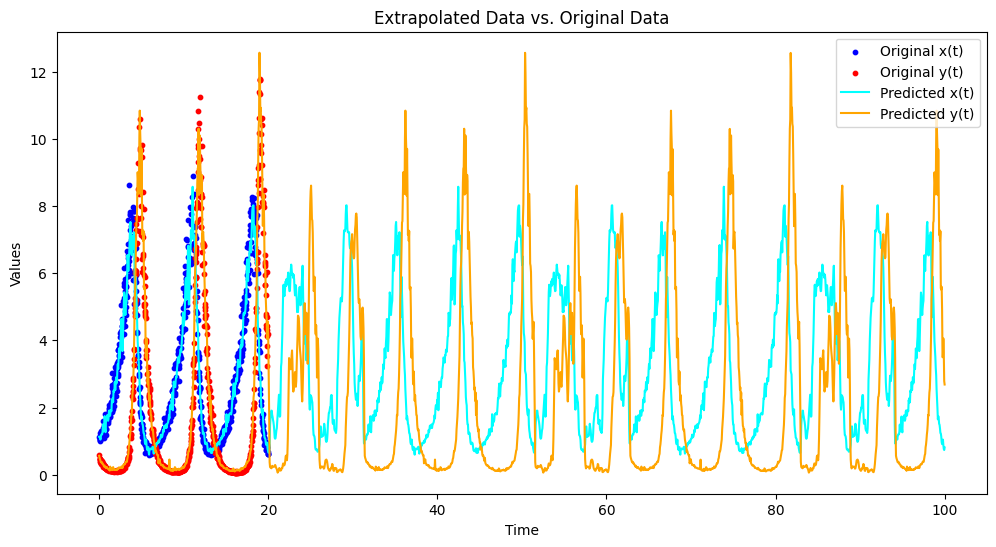

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
n_features=16
def fourier_features(t, scale=10):
    """Generate Fourier features for time input `t`."""
    freqs = torch.linspace(1.0, scale, n_features)
    features = torch.cat([torch.sin(t * freqs), torch.cos(t * freqs)], dim=1)
    return features

class FourierMLP(nn.Module):
    '''MLP with Fourier features for extrapolation of time series.'''
    def __init__(self):
        super(FourierMLP, self).__init__()
        self.fc1 = nn.Linear(2 * n_features, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(0.1)

    def forward(self, t):
        t_encoded = fourier_features(t)
        x = F.relu(self.fc1(t_encoded))
        #x = self.dropout(x)
        x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        x = F.relu(self.fc3(x))
        #x = self.dropout(x)
        x = F.relu(self.fc4(x))
        return self.fc5(x)

class TimeSeriesDataset(torch.utils.data.Dataset):
    '''Custom Dataset for loading time series data with missing values.'''
    def __init__(self, csv_file):
        data = pd.read_csv(csv_file, na_values='-')
        self.times = data['t'].values.astype(np.float32)
        self.x_values = data['x'].astype(np.float32).values
        self.y_values = data['y'].astype(np.float32).values

    def __len__(self):
        return len(self.times)

    def __getitem__(self, idx):
        t = self.times[idx]
        x = self.x_values[idx]
        y = self.y_values[idx]
        labels = np.array([0.0, 0.0], dtype=np.float32)
        mask = np.array([0.0, 0.0], dtype=np.float32)
        if not np.isnan(x):
            labels[0] = x
            mask[0] = 1.0
        if not np.isnan(y):
            labels[1] = y
            mask[1] = 1.0
        return torch.tensor([t]), torch.tensor(labels), torch.tensor(mask)

dataset = TimeSeriesDataset('data.csv')
trainloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

def loss_fn(outputs, labels, mask, delta=1.0):
    error = outputs - labels
    is_small_error = (error.abs() <= delta).float()
    squared_loss = 0.5 * error ** 2
    linear_loss = delta * (error.abs() - 0.5 * delta)
    loss = (is_small_error * squared_loss + (1 - is_small_error) * linear_loss) * mask
    loss = loss.sum() / mask.sum()
    return loss

net = FourierMLP()
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in range(300):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels, mask = data
        inputs = inputs.float()
        labels = labels.float()
        mask = mask.float()

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_fn(outputs, labels, mask)
        loss.backward()
        optimizer.step()

print('Finished Training')

plt.figure(figsize=(12, 6))

plt.scatter(dataset.times[~np.isnan(dataset.x_values)], dataset.x_values[~np.isnan(dataset.x_values)], label='Original x(t)', color='blue', s=10)

plt.scatter(dataset.times[~np.isnan(dataset.y_values)], dataset.y_values[~np.isnan(dataset.y_values)], label='Original y(t)', color='red', s=10)

with torch.no_grad():
    times = torch.linspace(0, 100, steps=2000)
    predicted = net(times.unsqueeze(1))
    predicted = predicted.numpy()

plt.plot(times.numpy(), predicted[:, 0], label='Predicted x(t)', color='cyan')
plt.plot(times.numpy(), predicted[:, 1], label='Predicted y(t)', color='orange')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Extrapolated Data vs. Original Data')
plt.show()
